# Example of TraceFitter with Hodgkin Huxley model

In [1]:
 from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms

# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA

input_current2 = np.stack((input_current0, input_current1))

params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

# input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt)),np.zeros(int(5*ms/dt)),np.ones(int(5*ms/dt)),np.zeros(int(5*ms/dt))])*nA

defaultclock.dt = dt

In [3]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [4]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

In [5]:
voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [6]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

# Generate Proper Input Format for the Problem
inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_trace = np.concatenate(([out_trace0], [out_trace1]))

## Problem description:

we have 2 input currents and two data "samples" recorded from the model 

We don't know what are the optimal conductances for our model, however we do know the expected ranges of the parameters:

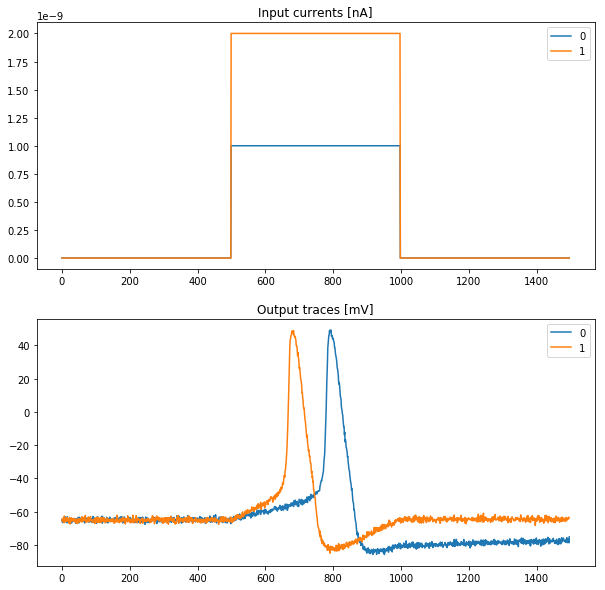

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(inp_trace[0].transpose(), label=0)
ax[0].plot(inp_trace[1].transpose(), label=1)
ax[0].set_title('Input currents [nA]')
ax[0].legend()

ax[1].plot(out_trace[0].transpose(), label=0);
ax[1].plot(out_trace[1].transpose(), label=1);
ax[1].legend()
ax[1].set_title('Output traces [mV]');

plt.savefig('hh_tutorial_input.png')


### Description 1:
we need to define our parameters and model with Equations object, important note, you have to identify the parameters you want to optimizer, by adding them as constant variables to the equaton

In [8]:
# Model for modelfitting
Cm=1*ufarad*cm**-2 * area
El=-65*mV
EK=-90*mV
ENa=50*mV
VT=-63*mV

eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
)

## Description 2:
After that it's time to pick an optimzer (type and it's method) and a metric:

In [9]:
n_opt = NevergradOptimizer()
metric = MSEMetric()

In [22]:
# pass parameters to the NeuronGroup
fitter = TraceFitter(model=eqs, 
                     input_var='I',
                     output_var='v',
                     input=inp_trace * amp,
                     output=out_trace*mV, dt=dt,
                     n_samples=10,
                     param_init={'v': -65*mV},
                     method='exponential_euler',)

In [23]:
res, error = fitter.fit(n_rounds=2,
                        optimizer=n_opt, metric=metric,
                        gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                        g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                        g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                        )

Round 0: fit (9.401696843714817e-05, 1.2189066745426425e-07, 8.098454258268693e-05) with error: 0.44159650787505067
Round 1: fit (4.222867177282197e-05, 7.504100120635022e-08, 4.772988880219001e-05) with error: 0.21516490325116963


In [24]:
res, error = fitter.fit(n_rounds=2,
                        optimizer=n_opt, metric=metric,
                        gl=[2*psiemens, 200*nsiemens],
                        g_na=[200* nsiemens, 0.4*msiemens],
                        g_kd=[200*nsiemens, 200*usiemens],
                        )

Round 0: fit (4.222867177282197e-05, 7.504100120635022e-08, 4.772988880219001e-05) with error: 0.5165218259614359
Round 1: fit (2.676589777337801e-05, 1.482336088690629e-07, 0.0001772869243329754) with error: 0.1665320942433037


In [25]:
# give information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'g_kd': 2.676589777337801e-05, 'gl': 1.482336088690629e-07, 'g_na': 0.0001772869243329754}
error 0.1665320942433037


In [26]:
all_output = fitter.results(format='dataframe')
print(all_output)

        g_kd            gl      g_na    errors
0   0.000106  1.626414e-07  0.000085  0.592760
1   0.000127  3.460398e-08  0.000097  0.950736
2   0.000094  9.145251e-08  0.000177  0.893888
3   0.000072  6.098138e-08  0.000297  1.501410
4   0.000146  9.793201e-08  0.000326  1.454464
5   0.000146  1.150174e-07  0.000296  1.375153
6   0.000123  8.708698e-08  0.000142  0.798152
7   0.000139  1.537338e-07  0.000114  0.545751
8   0.000094  1.218907e-07  0.000081  0.441597
9   0.000072  5.485899e-08  0.000214  1.102841
10  0.000109  1.327051e-07  0.000282  0.959752
11  0.000042  7.504100e-08  0.000048  0.215165
12  0.000043  1.032011e-07  0.000251  0.925332
13  0.000093  1.004261e-07  0.000193  0.884146
14  0.000071  4.045667e-08  0.000257  1.176640
15  0.000112  5.206553e-08  0.000110  0.906618
16  0.000143  5.547085e-08  0.000180  1.083369
17  0.000066  8.597328e-08  0.000263  1.388481
18  0.000092  4.086278e-08  0.000307  1.519367
19  0.000116  1.184885e-07  0.000140  0.356603
20  0.000053 

In [27]:
# visualization of the results
start_scope()
fits = fitter.generate_traces(params=None, param_init={'v': -65*mV})

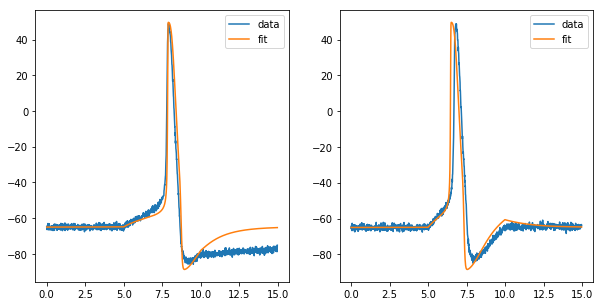

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(np.arange(len(out_trace[0]))*dt/ms, out_trace[0], label='data')
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV, label='fit')
ax[1].plot(np.arange(len(out_trace[1]))*dt/ms, out_trace[1], label='data')
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV, label='fit')
ax[0].legend()
ax[1].legend();
plt.savefig('hh_best_fit.png')